In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

import sys
import os.path as osp

SRC_SUBDIR = '../src/'
SRC_SUBDIR = osp.abspath(SRC_SUBDIR)
if SRC_SUBDIR not in sys.path:
    sys.path.insert(1, SRC_SUBDIR)
    

In [4]:
activities_df = pd.read_csv("../data/processed/cleaned_activities.csv")
activities_df.head()

,Record_Date,Eat Dinner,Eat Breakfast,Eat Lunch,Gratitude Jar,Meditation,Mindfulness Walk,Read For Fun,Take A Shower,Yoga
0,2022-10-27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mood_df = pd.read_csv("../data/processed/cleaned_moods.csv")
mood_df.head()

,Record_Date,average_feeling,satisfaction,motivation
0,2022-10-26,3.000000,3.0,3.0
1,2022-10-27,2.833333,2.0,4.0
2,2022-10-28,3.125000,4.0,2.0
3,2022-10-29,3.375000,3.0,3.0
4,2022-10-30,3.571429,4.0,4.0


In [11]:
avg_feelings_df = mood_df[['Record_Date','average_feeling']]
avg_feelings_df = avg_feelings_df.rename(columns={'average_feeling':'value'})

### 1 day lag and 3 day lag

In [8]:
ex_variable_names = activities_df.columns.to_list()
ex_variable_names.remove('Record_Date')

lagged_1day_features = []
for col in ex_variable_names:
    col_name = f'{col}_lag1'
    activities_df[col_name] = activities_df[col].shift(1)
    lagged_1day_features.append(col_name)

lagged_3day_features = []
for col in ex_variable_names:
    col_name = f'{col}_lag3'
    activities_df[col_name] = activities_df[col].shift(3)
    lagged_1day_features.append(col_name)

lagged_features = lagged_1day_features + lagged_3day_features

In [9]:
exvar_lagged_df = activities_df[lagged_features+['Record_Date']]

In [12]:
df = pd.merge(avg_feelings_df, exvar_lagged_df, on='Record_Date', how='inner')

In [13]:
fill_values = {}
for col in lagged_features:
    fill_values[col] = 0
    
df = df.fillna(value=fill_values)
df = df.dropna(subset=['value'])
# assuming that if I'm missing records then I just didn't do that activity

In [14]:
df.head()

,Record_Date,value,Eat Dinner_lag1,Eat Breakfast_lag1,Eat Lunch_lag1,Gratitude Jar_lag1,Meditation_lag1,Mindfulness Walk_lag1,Read For Fun_lag1,Take A Shower_lag1,Yoga_lag1,Eat Dinner_lag3,Eat Breakfast_lag3,Eat Lunch_lag3,Gratitude Jar_lag3,Meditation_lag3,Mindfulness Walk_lag3,Read For Fun_lag3,Take A Shower_lag3,Yoga_lag3
0,2022-10-27,2.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-28,3.125000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-29,3.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-30,3.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-31,3.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# lets examine mood on day after yoga vs no yoga days
df_box = df[['value', 'Yoga_lag1', 'Yoga_lag3']].dropna()

#map to labels for nicer x-axis
df_box['Yoga_Yesterday'] = df_box['Yoga_lag1'].map({0: 'No Yoga', 1: 'Yoga'})
df_box['Yoga_3_Days_Ago'] = df_box['Yoga_lag3'].map({0: 'No Yoga', 1: 'Yoga'})

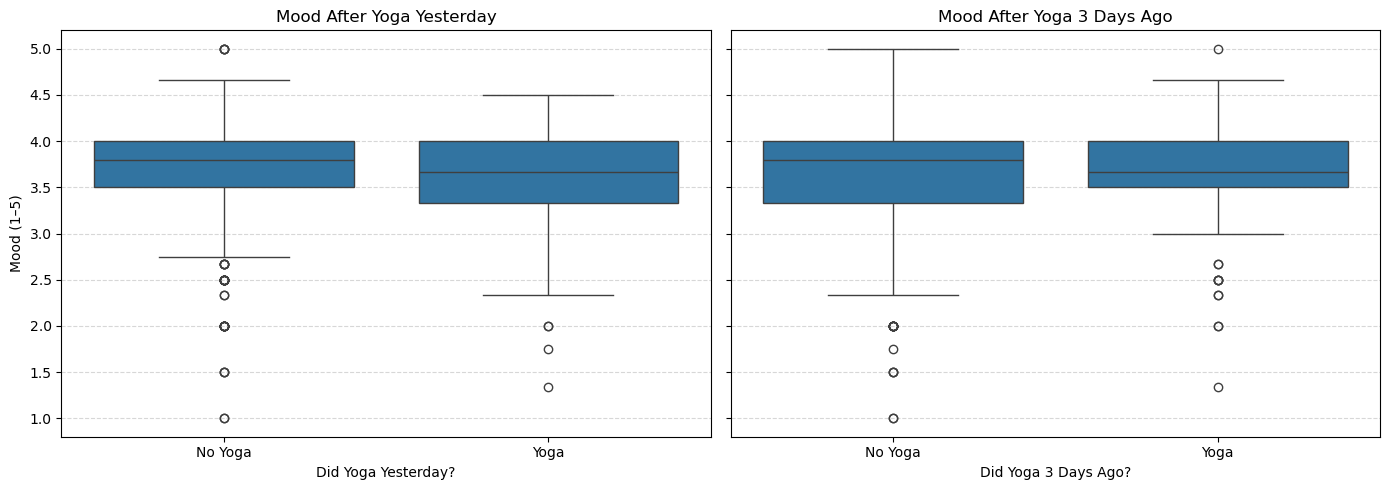

In [16]:
# Set up the subplot grid: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# First boxplot: Mood vs Yoga_Yesterday
sns.boxplot(ax=axes[0], x='Yoga_Yesterday', y='value', data=df_box)
axes[0].set_title("Mood After Yoga Yesterday")
axes[0].set_xlabel("Did Yoga Yesterday?")
axes[0].set_ylabel("Mood (1–5)")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Second boxplot: Mood vs Yoga_3_Days_Ago
sns.boxplot(ax=axes[1], x='Yoga_3_Days_Ago', y='value', data=df_box)
axes[1].set_title("Mood After Yoga 3 Days Ago")
axes[1].set_xlabel("Did Yoga 3 Days Ago?")
axes[1].set_ylabel("")  # No y-label to avoid redundancy
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

* middle 50% of mood values (from Q1 to Q3) is more consistent after doing yoga
* while the median mood isn’t higher, yoga days seem to produce more stable mood outcomes
* lower median mood could be due to confounding variables (e.g. doing yoga BECAUSE I had been feeling down)

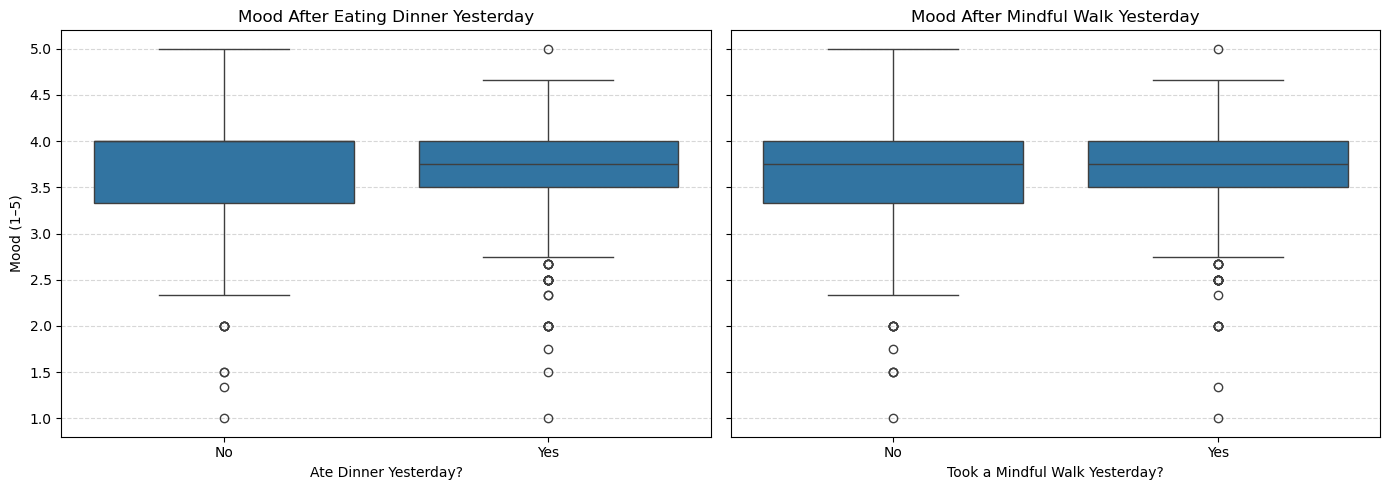

In [17]:
df_box = df[['value', 'Mindfulness Walk_lag1', 'Eat Dinner_lag1']].dropna()
df_box['Eat Dinner_lag1'] = df_box['Eat Dinner_lag1'].map({0: 'No', 1: 'Yes'})
df_box['Mindfulness Walk_lag1'] = df_box['Mindfulness Walk_lag1'].map({0: 'No', 1: 'Yes'})

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Dinner boxplot
sns.boxplot(ax=axes[0], x='Eat Dinner_lag1', y='value', data=df_box)
axes[0].set_title("Mood After Eating Dinner Yesterday")
axes[0].set_xlabel("Ate Dinner Yesterday?")
axes[0].set_ylabel("Mood (1–5)")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.5)

# Mindful Walk boxplot
sns.boxplot(ax=axes[1], x='Mindfulness Walk_lag1', y='value', data=df_box)
axes[1].set_title("Mood After Mindful Walk Yesterday")
axes[1].set_xlabel("Took a Mindful Walk Yesterday?")
axes[1].set_ylabel("")  # Already labeled on the left
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [18]:
df_box[df_box['Eat Dinner_lag1']=='no'].value.mean()

nan